In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import array
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
tfds.disable_progress_bar()

In [3]:
# Python program to convert .tsv file to .csv file
# importing pandas library
import pandas as pd

with open("amazon_reviews_us_Mobile_Electronics_v1_00.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        print(line)


Output hidden; open in https://colab.research.google.com to view.

In [4]:
amazon, info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incomplete9N828R/amazon_us_reviews-train.tfrecord


  0%|          | 0/104975 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


In [5]:
with open('/content/amazon_reviews_us_Mobile_Electronics_v1_00.tsv', 'rb') as f:
    data = f.readlines()

In [6]:
import re
tsv = open('amazon_reviews_us_Mobile_Electronics_v1_00.tsv', 'r')
fileContent =  tsv.read()
fileContent = re.sub("\t", ",", fileContent)
csv_file = open("amazon_reviews_us_Mobile_Electronics_v1_00.csv", "w")
csv_file.write(fileContent)
csv_file.close()

In [7]:
df = pd.read_csv('amazon_reviews_us_Mobile_Electronics_v1_00.csv', error_bad_lines=False)

b'Skipping line 7: expected 16 fields, saw 20\nSkipping line 8: expected 16 fields, saw 17\nSkipping line 10: expected 16 fields, saw 17\nSkipping line 11: expected 16 fields, saw 21\nSkipping line 12: expected 16 fields, saw 19\nSkipping line 13: expected 16 fields, saw 19\nSkipping line 15: expected 16 fields, saw 18\nSkipping line 16: expected 16 fields, saw 18\nSkipping line 18: expected 16 fields, saw 18\nSkipping line 20: expected 16 fields, saw 18\nSkipping line 25: expected 16 fields, saw 18\nSkipping line 27: expected 16 fields, saw 19\nSkipping line 28: expected 16 fields, saw 17\nSkipping line 29: expected 16 fields, saw 19\nSkipping line 30: expected 16 fields, saw 17\nSkipping line 33: expected 16 fields, saw 27\nSkipping line 35: expected 16 fields, saw 18\nSkipping line 36: expected 16 fields, saw 23\nSkipping line 40: expected 16 fields, saw 19\nSkipping line 44: expected 16 fields, saw 27\nSkipping line 46: expected 16 fields, saw 17\nSkipping line 48: expected 16 fiel

In [8]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5,0.0,0.0,N,Y,Very Happy!,As advertised. Everything works perfectly,I'm very happy with the camera. As a matter o...,2015-08-31
US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5,0.0,1.0,N,Y,five star,it's great,2015-08-31,NaN
US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31,NaN
US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31,NaN
US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2,0.0,0.0,N,Y,Cameras has battery issues,Be careful with these products,I have bought several of these cameras and th...,2015-08-31


In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [19]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

In [47]:
import tensorflow_datasets as tfds

# Fetch the dataset directly
mnist = tfds.image.MNIST()
# or by string name
mnist = tfds.builder('mnist')

# Describe the dataset with DatasetInfo
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

# Load data from disk as tf.data.Datasets
datasets = mnist.as_dataset()
train_dataset, test_dataset = datasets['train'], datasets['test']
assert isinstance(train_dataset, tf.data.Dataset)

# And convert the Dataset to NumPy arrays if you'd like
for example in tfds.as_numpy(train_dataset):
  image, label = example['image'], example['label']

In [53]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [54]:
tweet_df = df[['review_body','review_headline']]
print(tweet_df.shape)
tweet_df.head(5)

(39679, 2)


,review_body,review_headline
US,I'm very happy with the camera. As a matter o...,As advertised. Everything works perfectly
US,2015-08-31,it's great
US,2015-08-31,These work great and fit my life proof case fo...
US,2015-08-31,Work very well but couldn't get used to not he...
US,I have bought several of these cameras and th...,Be careful with these products


In [55]:
tweet_df["review_headline"].value_counts()

Five Stars                                                                                                                                                                                                                      609
One Star                                                                                                                                                                                                                        113
Good                                                                                                                                                                                                                            106
Four Stars                                                                                                                                                                                                                      105
good                                                                                    

In [56]:
sentiment_label = tweet_df.review_headline.factorize()
sentiment_label

(array([    0,     1,     2, ..., 35397, 35398,    -1]),
 Index(['As advertised. Everything works perfectly', 'it's great',
        'These work great and fit my life proof case for the iPhone 6',
        'Work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.',
        'Be careful with these products', 'Worked great for vacation',
        'Love it',
        'Worked with MHD Flasher for Android.  Used to flash performance tunes to BMW 135i/335i N54 engines.',
        'I bought this unit as a replacement for my portable fish finder. Works great as did the original. I replaced it because the original was accidentally damaged.',
        'Met my application needs very well.',
        ...
        'i would buy this more than twice awesome subs great amp and a good deal all around a great system',
        'Product did not function as it should.  Seller was horrible doing business with.',
        'its been more than a month that i had ordered for t

In [57]:
tweet = tweet_df
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [58]:
print(tokenizer.word_index)

{'review': 1, 'body': 2, 'headline': 3}


In [59]:
print(padded_sequence[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]


In [60]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           128       
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 16,779
Trainable params: 16,779
Non-trainable params: 0
____________________________________________________

In [61]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.6963 - accuracy: 0.0000e+00 - val_loss: 0.6972 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 224ms/step - loss: 0.6915 - accuracy: 1.0000 - val_loss: 0.7061 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 0s 222ms/step - loss: 0.6909 - accuracy: 1.0000 - val_loss: 0.7151 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 0s 225ms/step - loss: 0.6745 - accuracy: 1.0000 - val_loss: 0.7242 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 219ms/step - loss: 0.6728 - accuracy: 1.0000 - val_loss: 0.7337 - val_accuracy: 0.0000e+00


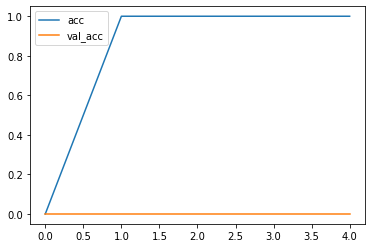

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

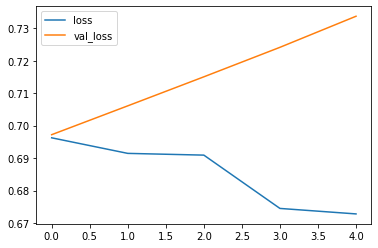

<Figure size 432x288 with 0 Axes>

In [63]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [64]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [65]:
test_sentence1 = "What a great watch. Both watches and strap "
predict_sentiment(test_sentence1)

test_sentence2 = "love watching all the episodes of Dexter"
predict_sentiment(test_sentence2)

Predicted label:  As advertised. Everything works perfectly
Predicted label:  As advertised. Everything works perfectly
